In [97]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [98]:
L = 5 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=3
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [99]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
       0.         |2 2 2 2 2>           242  
       1.         |2 2 2 2 1>           241  
       2.         |2 2 2 2 0>           240  
       3.         |2 2 2 1 2>           239  
       4.         |2 2 2 1 1>           238  
       5.         |2 2 2 1 0>           237  
       6.         |2 2 2 0 2>           236  
       7.         |2 2 2 0 1>           235  
       8.         |2 2 2 0 0>           234  
       9.         |2 2 1 2 2>           233  
      10.         |2 2 1 2 1>           232  
      11.         |2 2 1 2 0>           231  
      12.         |2 2 1 1 2>           230  
      13.         |2 2 1 1 1>           229  
      14.         |2 2 1 1 0>           228  
      15.         |2 2 1 0 2>           227  
      16.         |2 2 1 0 1>           226  
      17.         |2 2 1 0 0>           225  
      18.         |2 2 0 2 2>           224  
      19.         |2 2 0 2 1>           223  
      20.  

In [100]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [101]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [102]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [103]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [104]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [105]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [106]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [107]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [108]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [109]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-1.0416023  -0.0142565   0.15174042]


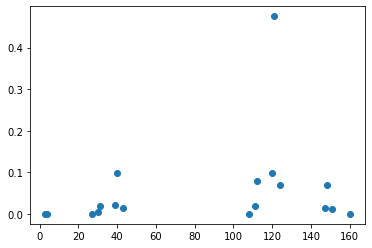

In [110]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvec[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")


In [111]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [112]:
def swap(m,n):
    swap_matrix = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    swap_matrix = sparse.csc_matrix(swap_matrix)
    for i in range(basis.Ns):
        state_m = basis.int_to_state(basis.Ns-i-1)[2*m+1]
        state_n = basis.int_to_state(basis.Ns-i-1)[2*n+1]
        string = list(basis.int_to_state(basis.Ns-i-1))
        string[2*m+1],string[2*n+1] = state_n,state_m
        string = "".join(string)
        string = string.replace(" ", "")
        string = string.replace("|","")
        string = string.replace(">", "")
        i_new = basis.Ns-1-basis.state_to_int(string)
        swap_matrix[i_new,i] = 1.
        
    return swap_matrix


def exp_gate(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = np.cos(theta/2)
    Matrix[8-1,8-1] = np.cos(theta/2)
    Matrix[8-2,8-2] = 0

    Matrix[8-3,8-3] = np.cos(theta/2)
    Matrix[8-4,8-4] = np.cos(theta/2)
    Matrix[8-5,8-5] = 0

    Matrix[8-6,8-6] = -np.cos(theta/2)
    Matrix[8-7,8-7] = np.cos(theta/2)
    Matrix[8-8,8-8] = -1j

    Matrix[8-0,8-4] = -1j*np.sin(theta/2)
    Matrix[8-4,8-0] = -1j*np.sin(theta/2)

    Matrix[8-1,8-3] = -1j*np.sin(theta/2)
    Matrix[8-3,8-1] = -1j*np.sin(theta/2)


    Matrix[8-5,8-2] = -1
    Matrix[8-2,8-5] = -1

    Matrix[8-6,8-7] = np.sin(theta/2)
    Matrix[8-7,8-6] = np.sin(theta/2)

    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full

In [113]:
def exp_gate_der(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = -np.sin(theta/2)/2
    Matrix[8-1,8-1] = -np.sin(theta/2)/2

    Matrix[8-3,8-3] = -np.sin(theta/2)/2
    Matrix[8-4,8-4] = -np.sin(theta/2)/2

    Matrix[8-6,8-6] = np.sin(theta/2)/2
    Matrix[8-7,8-7] = -np.sin(theta/2)/2

    Matrix[8-0,8-4] = -1j*np.cos(theta/2)/2
    Matrix[8-4,8-0] = -1j*np.cos(theta/2)/2

    Matrix[8-1,8-3] = -1j*np.cos(theta/2)/2
    Matrix[8-3,8-1] = -1j*np.cos(theta/2)/2



    Matrix[8-6,8-7] = np.cos(theta/2)/2
    Matrix[8-7,8-6] = np.cos(theta/2)/2
    
    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full




In [114]:
%time exp_gate_der(0,np.pi/3)

CPU times: user 334 µs, sys: 4 ms, total: 4.33 ms
Wall time: 3.13 ms


<243x243 sparse matrix of type '<class 'numpy.complex128'>'
	with 324 stored elements in COOrdinate format>

In [115]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [116]:
def R(i,theta):
    
    if i%13 == 0:
        return(exp_gate(0,theta))

    if i%13 == 1:
        return(exp_gate(1,theta))

    if i%13 == 2:
        return(exp_gate(2,theta))

    if i%13 == 3:
        return(exp_gate(3,theta))

    if i%13 == 4:
        return(rot_sigma_e(0,1,0,theta))


    if i%13 == 5:
        return(rot_sigma_e(0,2,0,theta))

    
    if i%13 == 6:
        return(rot_sigma_e(1,2,np.pi/2,theta))

    
    if i%13 == 7:
        return(rot_sigma_o(0,1,0,theta))


    if i%13 == 8:
        return(rot_sigma_o(0,2,0,theta))

    
    if i%13 == 9:
        return(rot_sigma_o(1,2,np.pi/2,theta))

    if i%13 == 10:
        return(rot_sigma_r(0,1,0,theta))


    if i%13 == 11:
        return(rot_sigma_r(0,2,0,theta))

    
    if i%13 == 12:
        return(rot_sigma_r(1,2,np.pi/2,theta))
        

def S(i,theta):
    
    if i%13 == 0:
        return(exp_gate_der(0,theta)@exp_gate(0,theta).T.conj())

    if i%13 == 1:
        return(exp_gate_der(1,theta)@exp_gate(1,theta).T.conj())
    
    if i%13 == 2:
        return(exp_gate_der(2,theta)@exp_gate(2,theta).T.conj())

    if i%13 == 3:
        return(exp_gate_der(3,theta)@exp_gate(3,theta).T.conj())

    if i%13 == 4:
        return(-1j*sigma_e(0,1,0))

    
    if i%13 == 5:
        return(-1j*sigma_e(0,2,0))

    
    if i%13 == 6:
        return(-1j*sigma_e(1,2,np.pi/2))
     
    if i%13 == 7:
        return(-1j*sigma_o(0,1,0))

    
    if i%13 == 8:
        return(-1j*sigma_o(0,2,0))

    
    if i%13 == 9:
        return(-1j*sigma_o(1,2,np.pi/2))

     
    if i%13 == 10:
        return(-1j*sigma_r(0,1,0))

    
    if i%13 == 11:
        return(-1j*sigma_r(0,2,0))
    

    if i%13 == 12:
        return(-1j*sigma_r(1,2,np.pi/2))

In [117]:
coeff = 13
stepp = 125
t_final = 25

In [118]:
expt_value = []
energyy = []

time_domain = np.linspace(0, t_final, stepp)

Y = []

In [119]:
for kkk in range(3):
    
    N=kkk+1
    start_point = np.random.rand(coeff*N)

    matr = full_ham_matrix.toarray()
    B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
    psi_d = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s2 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]

    def rhs(t,theta):

        print(datetime.datetime.now())
        for k in range(coeff*N):
            B[k] = R(k,theta[k])

        psi_b = psi_0
        for k in range(coeff*N):
            psi_b = B[coeff*N-1-k]@psi_b
        for i in range(L+1):
            psi_b = (Proj[i]+Proj_0[i])@psi_b
        norm_b = np.sqrt(np.real(np.conj(psi_b)@psi_b))
        psi_b = psi_b/norm_b



        psi_conj_b = np.conj(psi_b)

        print("start",datetime.datetime.now())

        for k in range(coeff*N):
            B[k] = S(k,theta[k])@R(k,theta[k])
            psi_d[k] = psi_0
            for i in range(coeff*N):
                psi_d[k] = B[coeff*N-1-i]@psi_d[k]
            B[k] = R(k,theta[k])

        print("stop_reduce",datetime.datetime.now())

        psi_conj_d = np.conj(psi_d)


        for k in range(coeff*N):
            for i in range(L+1):
                psi_d_1[k] = (Proj[i]+Proj_0[i])@psi_d[k]  
            psi_d_s1[k] = psi_d_1[k]/norm_b
            psi_d_s2[k] = -psi_b*(psi_conj_d[k]@psi_b+psi_conj_b@psi_d[k])
            psi_d[k] = psi_d_s1[k]+psi_d_s2[k]

        psi_conj_d = np.conj(psi_d)




        X = np.zeros((coeff*N,coeff*N),dtype = complex)
        Y = np.zeros(coeff*N,dtype = complex)


        X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

        Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)

        XX = np.einsum("il,l->i",psi_conj_d,psi_b)

        YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)

        YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
        YY = YY_1*YY_2
        XX = np.outer(XX,XX)
        X_r = 2*np.real(X+XX)
        Y_i = 2*np.real(Y+YY)
        result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
        print(datetime.datetime.now())

        print(t)

        return result

    # RK-4 method
    def rk4(x0,y0,xn,n):
        global Y

        # Calculating step size
        h = (xn-x0)/n

        #print('\n--------SOLUTION--------')
        #print('-------------------------')    
        #print('x0\ty0\tyn')
        #print('-------------------------')
        for i in range(n):
            k1 = h * (rhs(x0, y0))
            k2 = h * (rhs((x0+h/2), (y0+k1/2)))
            k3 = h * (rhs((x0+h/2), (y0+k2/2)))
            k4 = h * (rhs((x0+h), (y0+k3)))
            k = (k1+2*k2+2*k3+k4)/6
            yn = y0 + k
            #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
            #print('-------------------------')
            y0 = yn
            x0 = x0+h
            Y.append(y0)

        #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

    # Inputs
    #print('Enter initial conditions:')
    #x0 = float(input('x0 = '))
    #y0 = float(input('y0 = '))

    #print('Enter calculation point: ')
    #xn = float(input('xn = '))

    #print('Enter number of steps:')
    #step = int(input('Number of steps = '))

    # RK4 method call
    #start_point = 0.001*np.ones(coeff*N)




    Y = []
    #start_point = np.zeros(coeff*N)

    rk4(0,start_point,t_final,stepp)
    def var_ansatz(theta,psi_0):
        psi = psi_0
        for i in range(coeff*N):
            psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

        return psi
    psi = var_ansatz(start_point,psi_0)
    psi_ground = eigenvec[:,0]
    expt_value_u = np.zeros(len(time_domain))
    energy = np.zeros(len(time_domain))

    psi = var_ansatz(start_point,psi_0)
    for tt in range(len(time_domain)):
        theta = []
        for i in range(coeff*N):
            theta.append(Y[tt][i])


        psi_var = var_ansatz(theta,psi_0)
        for i in range(L+1):
            psi_var = (Proj[i]+Proj_0[i])@psi_var
        norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

        expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
        energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)
        
    expt_value.append(expt_value_u)
    energyy.append(energy)


    

2022-08-14 17:20:09.696642
start 2022-08-14 17:20:09.756427
stop_reduce 2022-08-14 17:20:09.901829
2022-08-14 17:20:09.913857
0
2022-08-14 17:20:09.913934
start 2022-08-14 17:20:09.970408
stop_reduce 2022-08-14 17:20:10.115907
2022-08-14 17:20:10.127141
0.1
2022-08-14 17:20:10.127205
start 2022-08-14 17:20:10.184537
stop_reduce 2022-08-14 17:20:10.331400
2022-08-14 17:20:10.343171
0.1
2022-08-14 17:20:10.343251
start 2022-08-14 17:20:10.399367
stop_reduce 2022-08-14 17:20:10.546835
2022-08-14 17:20:10.557480
0.2
2022-08-14 17:20:10.557544
start 2022-08-14 17:20:10.614259
stop_reduce 2022-08-14 17:20:10.768754
2022-08-14 17:20:10.781422
0.2
2022-08-14 17:20:10.781526
start 2022-08-14 17:20:10.838762
stop_reduce 2022-08-14 17:20:10.991408
2022-08-14 17:20:11.003436
0.30000000000000004
2022-08-14 17:20:11.003507
start 2022-08-14 17:20:11.062190
stop_reduce 2022-08-14 17:20:11.218840
2022-08-14 17:20:11.229712
0.30000000000000004
2022-08-14 17:20:11.229764
start 2022-08-14 17:20:11.285940


stop_reduce 2022-08-14 17:20:23.413822
2022-08-14 17:20:23.425297
3.1000000000000005
2022-08-14 17:20:23.425342
start 2022-08-14 17:20:23.487955
stop_reduce 2022-08-14 17:20:23.639021
2022-08-14 17:20:23.650702
3.1000000000000005
2022-08-14 17:20:23.650933
start 2022-08-14 17:20:23.709636
stop_reduce 2022-08-14 17:20:23.861063
2022-08-14 17:20:23.871991
3.2000000000000006
2022-08-14 17:20:23.872041
start 2022-08-14 17:20:23.930967
stop_reduce 2022-08-14 17:20:24.083370
2022-08-14 17:20:24.095917
3.2000000000000006
2022-08-14 17:20:24.096110
start 2022-08-14 17:20:24.155323
stop_reduce 2022-08-14 17:20:24.306630
2022-08-14 17:20:24.318988
3.3000000000000007
2022-08-14 17:20:24.319053
start 2022-08-14 17:20:24.378267
stop_reduce 2022-08-14 17:20:24.533145
2022-08-14 17:20:24.545248
3.3000000000000007
2022-08-14 17:20:24.545312
start 2022-08-14 17:20:24.603951
stop_reduce 2022-08-14 17:20:24.755201
2022-08-14 17:20:24.766789
3.400000000000001
2022-08-14 17:20:24.766968
start 2022-08-14 17

stop_reduce 2022-08-14 17:20:36.375090
2022-08-14 17:20:36.386621
5.900000000000002
2022-08-14 17:20:36.386667
start 2022-08-14 17:20:36.444005
stop_reduce 2022-08-14 17:20:36.608272
2022-08-14 17:20:36.621845
6.000000000000003
2022-08-14 17:20:36.621905
start 2022-08-14 17:20:36.687144
stop_reduce 2022-08-14 17:20:36.862326
2022-08-14 17:20:36.875485
6.000000000000003
2022-08-14 17:20:36.875540
start 2022-08-14 17:20:36.936093
stop_reduce 2022-08-14 17:20:37.093741
2022-08-14 17:20:37.106922
6.100000000000002
2022-08-14 17:20:37.106966
start 2022-08-14 17:20:37.165508
stop_reduce 2022-08-14 17:20:37.327082
2022-08-14 17:20:37.340173
6.100000000000002
2022-08-14 17:20:37.340258
start 2022-08-14 17:20:37.402582
stop_reduce 2022-08-14 17:20:37.563577
2022-08-14 17:20:37.575447
6.200000000000003
2022-08-14 17:20:37.575518
start 2022-08-14 17:20:37.636041
stop_reduce 2022-08-14 17:20:37.805401
2022-08-14 17:20:37.819648
6.200000000000003
2022-08-14 17:20:37.819730
start 2022-08-14 17:20:37

stop_reduce 2022-08-14 17:20:49.786804
2022-08-14 17:20:49.798865
8.8
2022-08-14 17:20:49.798929
start 2022-08-14 17:20:49.859552
stop_reduce 2022-08-14 17:20:50.021819
2022-08-14 17:20:50.033875
8.8
2022-08-14 17:20:50.033932
start 2022-08-14 17:20:50.093597
stop_reduce 2022-08-14 17:20:50.254243
2022-08-14 17:20:50.265670
8.9
2022-08-14 17:20:50.265717
start 2022-08-14 17:20:50.323228
stop_reduce 2022-08-14 17:20:50.480137
2022-08-14 17:20:50.493219
8.9
2022-08-14 17:20:50.493293
start 2022-08-14 17:20:50.553619
stop_reduce 2022-08-14 17:20:50.710652
2022-08-14 17:20:50.722093
9.0
2022-08-14 17:20:50.722159
start 2022-08-14 17:20:50.780586
stop_reduce 2022-08-14 17:20:50.946707
2022-08-14 17:20:50.959383
9.0
2022-08-14 17:20:50.959460
start 2022-08-14 17:20:51.022868
stop_reduce 2022-08-14 17:20:51.190028
2022-08-14 17:20:51.202470
9.1
2022-08-14 17:20:51.202591
start 2022-08-14 17:20:51.265894
stop_reduce 2022-08-14 17:20:51.429015
2022-08-14 17:20:51.441398
9.1
2022-08-14 17:20:51.

stop_reduce 2022-08-14 17:21:02.765032
2022-08-14 17:21:02.776715
11.69999999999999
2022-08-14 17:21:02.776763
start 2022-08-14 17:21:02.833667
stop_reduce 2022-08-14 17:21:02.984679
2022-08-14 17:21:02.996712
11.69999999999999
2022-08-14 17:21:02.996771
start 2022-08-14 17:21:03.053831
stop_reduce 2022-08-14 17:21:03.204698
2022-08-14 17:21:03.216343
11.79999999999999
2022-08-14 17:21:03.216404
start 2022-08-14 17:21:03.273407
stop_reduce 2022-08-14 17:21:03.424194
2022-08-14 17:21:03.435752
11.79999999999999
2022-08-14 17:21:03.435807
start 2022-08-14 17:21:03.493004
stop_reduce 2022-08-14 17:21:03.645241
2022-08-14 17:21:03.656870
11.89999999999999
2022-08-14 17:21:03.656918
start 2022-08-14 17:21:03.713602
stop_reduce 2022-08-14 17:21:03.864599
2022-08-14 17:21:03.876223
11.89999999999999
2022-08-14 17:21:03.876267
start 2022-08-14 17:21:03.933263
stop_reduce 2022-08-14 17:21:04.084388
2022-08-14 17:21:04.095956
11.99999999999999
2022-08-14 17:21:04.096008
start 2022-08-14 17:21:04

stop_reduce 2022-08-14 17:21:15.381102
2022-08-14 17:21:15.392816
14.49999999999998
2022-08-14 17:21:15.392886
start 2022-08-14 17:21:15.450955
stop_reduce 2022-08-14 17:21:15.606816
2022-08-14 17:21:15.618531
14.59999999999998
2022-08-14 17:21:15.618597
start 2022-08-14 17:21:15.677163
stop_reduce 2022-08-14 17:21:15.840211
2022-08-14 17:21:15.852642
14.59999999999998
2022-08-14 17:21:15.852709
start 2022-08-14 17:21:15.913159
stop_reduce 2022-08-14 17:21:16.075077
2022-08-14 17:21:16.086781
14.69999999999998
2022-08-14 17:21:16.086849
start 2022-08-14 17:21:16.147124
stop_reduce 2022-08-14 17:21:16.311032
2022-08-14 17:21:16.323036
14.69999999999998
2022-08-14 17:21:16.323090
start 2022-08-14 17:21:16.383256
stop_reduce 2022-08-14 17:21:16.545760
2022-08-14 17:21:16.558033
14.79999999999998
2022-08-14 17:21:16.558101
start 2022-08-14 17:21:16.618290
stop_reduce 2022-08-14 17:21:16.780213
2022-08-14 17:21:16.792100
14.79999999999998
2022-08-14 17:21:16.792155
start 2022-08-14 17:21:16

stop_reduce 2022-08-14 17:21:29.362253
2022-08-14 17:21:29.378499
17.39999999999997
2022-08-14 17:21:29.378593
start 2022-08-14 17:21:29.460043
stop_reduce 2022-08-14 17:21:29.681624
2022-08-14 17:21:29.698457
17.39999999999997
2022-08-14 17:21:29.698812
start 2022-08-14 17:21:29.782304
stop_reduce 2022-08-14 17:21:30.013632
2022-08-14 17:21:30.030501
17.49999999999997
2022-08-14 17:21:30.030591
start 2022-08-14 17:21:30.114536
stop_reduce 2022-08-14 17:21:30.342113
2022-08-14 17:21:30.358967
17.49999999999997
2022-08-14 17:21:30.359067
start 2022-08-14 17:21:30.443055
stop_reduce 2022-08-14 17:21:30.665516
2022-08-14 17:21:30.681579
17.59999999999997
2022-08-14 17:21:30.681942
start 2022-08-14 17:21:30.760721
stop_reduce 2022-08-14 17:21:30.969776
2022-08-14 17:21:30.985476
17.59999999999997
2022-08-14 17:21:30.985582
start 2022-08-14 17:21:31.064296
stop_reduce 2022-08-14 17:21:31.282827
2022-08-14 17:21:31.299080
17.69999999999997
2022-08-14 17:21:31.299165
start 2022-08-14 17:21:31

stop_reduce 2022-08-14 17:21:47.645986
2022-08-14 17:21:47.663382
20.19999999999996
2022-08-14 17:21:47.663484
start 2022-08-14 17:21:47.751525
stop_reduce 2022-08-14 17:21:47.985466
2022-08-14 17:21:48.002872
20.29999999999996
2022-08-14 17:21:48.002985
start 2022-08-14 17:21:48.091062
stop_reduce 2022-08-14 17:21:48.325465
2022-08-14 17:21:48.342728
20.29999999999996
2022-08-14 17:21:48.342827
start 2022-08-14 17:21:48.430342
stop_reduce 2022-08-14 17:21:48.664841
2022-08-14 17:21:48.682334
20.39999999999996
2022-08-14 17:21:48.682597
start 2022-08-14 17:21:48.770461
stop_reduce 2022-08-14 17:21:49.005521
2022-08-14 17:21:49.022902
20.39999999999996
2022-08-14 17:21:49.023013
start 2022-08-14 17:21:49.111331
stop_reduce 2022-08-14 17:21:49.346440
2022-08-14 17:21:49.363801
20.49999999999996
2022-08-14 17:21:49.363908
start 2022-08-14 17:21:49.452310
stop_reduce 2022-08-14 17:21:49.687832
2022-08-14 17:21:49.705205
20.49999999999996
2022-08-14 17:21:49.705308
start 2022-08-14 17:21:49

stop_reduce 2022-08-14 17:22:07.159549
2022-08-14 17:22:07.177071
23.09999999999995
2022-08-14 17:22:07.177169
start 2022-08-14 17:22:07.267775
stop_reduce 2022-08-14 17:22:07.526215
2022-08-14 17:22:07.543361
23.09999999999995
2022-08-14 17:22:07.543455
start 2022-08-14 17:22:07.630801
stop_reduce 2022-08-14 17:22:07.866606
2022-08-14 17:22:07.884040
23.19999999999995
2022-08-14 17:22:07.884137
start 2022-08-14 17:22:07.972818
stop_reduce 2022-08-14 17:22:08.208066
2022-08-14 17:22:08.225382
23.19999999999995
2022-08-14 17:22:08.225478
start 2022-08-14 17:22:08.316526
stop_reduce 2022-08-14 17:22:08.549917
2022-08-14 17:22:08.567149
23.29999999999995
2022-08-14 17:22:08.567241
start 2022-08-14 17:22:08.654680
stop_reduce 2022-08-14 17:22:08.887951
2022-08-14 17:22:08.905152
23.29999999999995
2022-08-14 17:22:08.905239
start 2022-08-14 17:22:08.992924
stop_reduce 2022-08-14 17:22:09.226608
2022-08-14 17:22:09.243853
23.39999999999995
2022-08-14 17:22:09.243953
start 2022-08-14 17:22:09

stop_reduce 2022-08-14 17:22:41.016128
2022-08-14 17:22:41.049830
1.0
2022-08-14 17:22:41.049941
start 2022-08-14 17:22:41.222200
stop_reduce 2022-08-14 17:22:41.636099
2022-08-14 17:22:41.664618
1.0
2022-08-14 17:22:41.664687
start 2022-08-14 17:22:41.804518
stop_reduce 2022-08-14 17:22:42.193855
2022-08-14 17:22:42.221506
1.1
2022-08-14 17:22:42.221736
start 2022-08-14 17:22:42.360129
stop_reduce 2022-08-14 17:22:42.742108
2022-08-14 17:22:42.770521
1.1
2022-08-14 17:22:42.770608
start 2022-08-14 17:22:42.916217
stop_reduce 2022-08-14 17:22:43.321270
2022-08-14 17:22:43.350645
1.2
2022-08-14 17:22:43.350909
start 2022-08-14 17:22:43.490534
stop_reduce 2022-08-14 17:22:43.833900
2022-08-14 17:22:43.858925
1.2
2022-08-14 17:22:43.859005
start 2022-08-14 17:22:43.987876
stop_reduce 2022-08-14 17:22:44.318248
2022-08-14 17:22:44.341299
1.3
2022-08-14 17:22:44.341382
start 2022-08-14 17:22:44.458239
stop_reduce 2022-08-14 17:22:44.771223
2022-08-14 17:22:44.794205
1.3
2022-08-14 17:22:44.

stop_reduce 2022-08-14 17:23:09.389203
2022-08-14 17:23:09.411833
4.000000000000001
2022-08-14 17:23:09.411894
start 2022-08-14 17:23:09.525847
stop_reduce 2022-08-14 17:23:09.836165
2022-08-14 17:23:09.858707
4.000000000000001
2022-08-14 17:23:09.858762
start 2022-08-14 17:23:09.973010
stop_reduce 2022-08-14 17:23:10.289150
2022-08-14 17:23:10.312135
4.1000000000000005
2022-08-14 17:23:10.312191
start 2022-08-14 17:23:10.428722
stop_reduce 2022-08-14 17:23:10.741957
2022-08-14 17:23:10.764614
4.1000000000000005
2022-08-14 17:23:10.764669
start 2022-08-14 17:23:10.879012
stop_reduce 2022-08-14 17:23:11.190596
2022-08-14 17:23:11.213160
4.200000000000001
2022-08-14 17:23:11.213254
start 2022-08-14 17:23:11.327629
stop_reduce 2022-08-14 17:23:11.636074
2022-08-14 17:23:11.658961
4.200000000000001
2022-08-14 17:23:11.659019
start 2022-08-14 17:23:11.774708
stop_reduce 2022-08-14 17:23:12.089505
2022-08-14 17:23:12.112656
4.300000000000001
2022-08-14 17:23:12.112714
start 2022-08-14 17:23:

stop_reduce 2022-08-14 17:23:36.494300
2022-08-14 17:23:36.517432
6.800000000000003
2022-08-14 17:23:36.517487
start 2022-08-14 17:23:36.630879
stop_reduce 2022-08-14 17:23:36.939226
2022-08-14 17:23:36.961699
6.900000000000003
2022-08-14 17:23:36.961755
start 2022-08-14 17:23:37.074689
stop_reduce 2022-08-14 17:23:37.383348
2022-08-14 17:23:37.406361
6.900000000000003
2022-08-14 17:23:37.406417
start 2022-08-14 17:23:37.520014
stop_reduce 2022-08-14 17:23:37.827770
2022-08-14 17:23:37.850339
7.0000000000000036
2022-08-14 17:23:37.850397
start 2022-08-14 17:23:37.963149
stop_reduce 2022-08-14 17:23:38.270092
2022-08-14 17:23:38.292699
7.0000000000000036
2022-08-14 17:23:38.292756
start 2022-08-14 17:23:38.405824
stop_reduce 2022-08-14 17:23:38.716156
2022-08-14 17:23:38.738512
7.100000000000003
2022-08-14 17:23:38.738559
start 2022-08-14 17:23:38.851018
stop_reduce 2022-08-14 17:23:39.159192
2022-08-14 17:23:39.181695
7.100000000000003
2022-08-14 17:23:39.181975
start 2022-08-14 17:23:

stop_reduce 2022-08-14 17:24:04.537019
2022-08-14 17:24:04.561519
9.699999999999998
2022-08-14 17:24:04.561586
start 2022-08-14 17:24:04.684045
stop_reduce 2022-08-14 17:24:05.019635
2022-08-14 17:24:05.043773
9.799999999999997
2022-08-14 17:24:05.043838
start 2022-08-14 17:24:05.166494
stop_reduce 2022-08-14 17:24:05.494541
2022-08-14 17:24:05.518227
9.799999999999997
2022-08-14 17:24:05.518284
start 2022-08-14 17:24:05.637955
stop_reduce 2022-08-14 17:24:05.982427
2022-08-14 17:24:06.011687
9.899999999999997
2022-08-14 17:24:06.011774
start 2022-08-14 17:24:06.156990
stop_reduce 2022-08-14 17:24:06.550484
2022-08-14 17:24:06.578848
9.899999999999997
2022-08-14 17:24:06.578936
start 2022-08-14 17:24:06.721641
stop_reduce 2022-08-14 17:24:07.112566
2022-08-14 17:24:07.140926
9.999999999999996
2022-08-14 17:24:07.141015
start 2022-08-14 17:24:07.285538
stop_reduce 2022-08-14 17:24:07.684986
2022-08-14 17:24:07.713941
9.999999999999996
2022-08-14 17:24:07.714017
start 2022-08-14 17:24:07

stop_reduce 2022-08-14 17:24:33.368776
2022-08-14 17:24:33.391326
12.599999999999987
2022-08-14 17:24:33.391390
start 2022-08-14 17:24:33.504464
stop_reduce 2022-08-14 17:24:33.809215
2022-08-14 17:24:33.831716
12.599999999999987
2022-08-14 17:24:33.831764
start 2022-08-14 17:24:33.945730
stop_reduce 2022-08-14 17:24:34.251201
2022-08-14 17:24:34.273645
12.699999999999987
2022-08-14 17:24:34.273698
start 2022-08-14 17:24:34.388336
stop_reduce 2022-08-14 17:24:34.690664
2022-08-14 17:24:34.712829
12.699999999999987
2022-08-14 17:24:34.712884
start 2022-08-14 17:24:34.826145
stop_reduce 2022-08-14 17:24:35.130201
2022-08-14 17:24:35.152514
12.799999999999986
2022-08-14 17:24:35.152570
start 2022-08-14 17:24:35.267271
stop_reduce 2022-08-14 17:24:35.574942
2022-08-14 17:24:35.597384
12.799999999999986
2022-08-14 17:24:35.597441
start 2022-08-14 17:24:35.712167
stop_reduce 2022-08-14 17:24:36.017301
2022-08-14 17:24:36.039858
12.899999999999986
2022-08-14 17:24:36.039917
start 2022-08-14 1

stop_reduce 2022-08-14 17:25:00.754839
2022-08-14 17:25:00.782736
15.399999999999977
2022-08-14 17:25:00.782825
start 2022-08-14 17:25:00.916374
stop_reduce 2022-08-14 17:25:01.282122
2022-08-14 17:25:01.310267
15.499999999999977
2022-08-14 17:25:01.310512
start 2022-08-14 17:25:01.447660
stop_reduce 2022-08-14 17:25:01.823955
2022-08-14 17:25:01.851238
15.499999999999977
2022-08-14 17:25:01.851327
start 2022-08-14 17:25:01.986830
stop_reduce 2022-08-14 17:25:02.354875
2022-08-14 17:25:02.385159
15.599999999999977
2022-08-14 17:25:02.385261
start 2022-08-14 17:25:02.524808
stop_reduce 2022-08-14 17:25:02.890646
2022-08-14 17:25:02.917541
15.599999999999977
2022-08-14 17:25:02.917636
start 2022-08-14 17:25:03.052997
stop_reduce 2022-08-14 17:25:03.416489
2022-08-14 17:25:03.443048
15.699999999999976
2022-08-14 17:25:03.443132
start 2022-08-14 17:25:03.579266
stop_reduce 2022-08-14 17:25:03.944732
2022-08-14 17:25:03.970734
15.699999999999976
2022-08-14 17:25:03.970790
start 2022-08-14 1

stop_reduce 2022-08-14 17:25:28.196947
2022-08-14 17:25:28.219434
18.29999999999997
2022-08-14 17:25:28.219483
start 2022-08-14 17:25:28.334523
stop_reduce 2022-08-14 17:25:28.646688
2022-08-14 17:25:28.669354
18.29999999999997
2022-08-14 17:25:28.669408
start 2022-08-14 17:25:28.784999
stop_reduce 2022-08-14 17:25:29.099569
2022-08-14 17:25:29.122254
18.399999999999967
2022-08-14 17:25:29.122314
start 2022-08-14 17:25:29.237501
stop_reduce 2022-08-14 17:25:29.552761
2022-08-14 17:25:29.575248
18.399999999999967
2022-08-14 17:25:29.575301
start 2022-08-14 17:25:29.690582
stop_reduce 2022-08-14 17:25:30.005493
2022-08-14 17:25:30.028250
18.499999999999968
2022-08-14 17:25:30.028315
start 2022-08-14 17:25:30.144020
stop_reduce 2022-08-14 17:25:30.456023
2022-08-14 17:25:30.478791
18.499999999999968
2022-08-14 17:25:30.478843
start 2022-08-14 17:25:30.594788
stop_reduce 2022-08-14 17:25:30.907732
2022-08-14 17:25:30.930855
18.599999999999966
2022-08-14 17:25:30.930916
start 2022-08-14 17:

stop_reduce 2022-08-14 17:25:53.929485
2022-08-14 17:25:53.952524
21.09999999999996
2022-08-14 17:25:53.952579
start 2022-08-14 17:25:54.070211
stop_reduce 2022-08-14 17:25:54.385216
2022-08-14 17:25:54.408276
21.199999999999957
2022-08-14 17:25:54.408336
start 2022-08-14 17:25:54.524017
stop_reduce 2022-08-14 17:25:54.837135
2022-08-14 17:25:54.859621
21.199999999999957
2022-08-14 17:25:54.859678
start 2022-08-14 17:25:54.975164
stop_reduce 2022-08-14 17:25:55.286243
2022-08-14 17:25:55.308772
21.299999999999958
2022-08-14 17:25:55.308829
start 2022-08-14 17:25:55.424530
stop_reduce 2022-08-14 17:25:55.735593
2022-08-14 17:25:55.758138
21.299999999999958
2022-08-14 17:25:55.758191
start 2022-08-14 17:25:55.872579
stop_reduce 2022-08-14 17:25:56.184521
2022-08-14 17:25:56.207080
21.399999999999956
2022-08-14 17:25:56.207134
start 2022-08-14 17:25:56.322459
stop_reduce 2022-08-14 17:25:56.634999
2022-08-14 17:25:56.657560
21.399999999999956
2022-08-14 17:25:56.657616
start 2022-08-14 17

stop_reduce 2022-08-14 17:26:19.642244
2022-08-14 17:26:19.665432
23.999999999999947
2022-08-14 17:26:19.665500
start 2022-08-14 17:26:19.781564
stop_reduce 2022-08-14 17:26:20.094223
2022-08-14 17:26:20.117075
23.999999999999947
2022-08-14 17:26:20.117131
start 2022-08-14 17:26:20.233334
stop_reduce 2022-08-14 17:26:20.547526
2022-08-14 17:26:20.570139
24.099999999999948
2022-08-14 17:26:20.570200
start 2022-08-14 17:26:20.685833
stop_reduce 2022-08-14 17:26:20.999687
2022-08-14 17:26:21.022406
24.099999999999948
2022-08-14 17:26:21.022460
start 2022-08-14 17:26:21.137817
stop_reduce 2022-08-14 17:26:21.450295
2022-08-14 17:26:21.472832
24.199999999999946
2022-08-14 17:26:21.472893
start 2022-08-14 17:26:21.588664
stop_reduce 2022-08-14 17:26:21.898384
2022-08-14 17:26:21.920977
24.199999999999946
2022-08-14 17:26:21.921028
start 2022-08-14 17:26:22.035828
stop_reduce 2022-08-14 17:26:22.345654
2022-08-14 17:26:22.368150
24.299999999999947
2022-08-14 17:26:22.368208
start 2022-08-14 1

start 2022-08-14 17:27:10.089460
stop_reduce 2022-08-14 17:27:10.570502
2022-08-14 17:27:10.604941
1.9999999999999998
2022-08-14 17:27:10.605005
start 2022-08-14 17:27:10.779911
stop_reduce 2022-08-14 17:27:11.259669
2022-08-14 17:27:11.294076
1.9999999999999998
2022-08-14 17:27:11.294240
start 2022-08-14 17:27:11.468061
stop_reduce 2022-08-14 17:27:11.950991
2022-08-14 17:27:11.985232
2.0999999999999996
2022-08-14 17:27:11.985292
start 2022-08-14 17:27:12.158331
stop_reduce 2022-08-14 17:27:12.642326
2022-08-14 17:27:12.676479
2.0999999999999996
2022-08-14 17:27:12.676534
start 2022-08-14 17:27:12.851810
stop_reduce 2022-08-14 17:27:13.330363
2022-08-14 17:27:13.364862
2.1999999999999997
2022-08-14 17:27:13.364927
start 2022-08-14 17:27:13.552612
stop_reduce 2022-08-14 17:27:14.038637
2022-08-14 17:27:14.073208
2.1999999999999997
2022-08-14 17:27:14.073266
start 2022-08-14 17:27:14.246670
stop_reduce 2022-08-14 17:27:14.713110
2022-08-14 17:27:14.745522
2.3
2022-08-14 17:27:14.745581


start 2022-08-14 17:27:49.204587
stop_reduce 2022-08-14 17:27:49.685366
2022-08-14 17:27:49.718783
4.900000000000001
2022-08-14 17:27:49.718843
start 2022-08-14 17:27:49.890672
stop_reduce 2022-08-14 17:27:50.367499
2022-08-14 17:27:50.401882
4.900000000000001
2022-08-14 17:27:50.401939
start 2022-08-14 17:27:50.574412
stop_reduce 2022-08-14 17:27:51.055980
2022-08-14 17:27:51.090448
5.000000000000002
2022-08-14 17:27:51.090508
start 2022-08-14 17:27:51.263255
stop_reduce 2022-08-14 17:27:51.739234
2022-08-14 17:27:51.772788
5.000000000000002
2022-08-14 17:27:51.772846
start 2022-08-14 17:27:51.944696
stop_reduce 2022-08-14 17:27:52.422949
2022-08-14 17:27:52.457242
5.100000000000001
2022-08-14 17:27:52.457298
start 2022-08-14 17:27:52.631053
stop_reduce 2022-08-14 17:27:53.109148
2022-08-14 17:27:53.143548
5.100000000000001
2022-08-14 17:27:53.143605
start 2022-08-14 17:27:53.316241
stop_reduce 2022-08-14 17:27:53.792242
2022-08-14 17:27:53.825665
5.200000000000002
2022-08-14 17:27:53

start 2022-08-14 17:28:28.423560
stop_reduce 2022-08-14 17:28:28.909230
2022-08-14 17:28:28.943551
7.700000000000004
2022-08-14 17:28:28.943609
start 2022-08-14 17:28:29.118042
stop_reduce 2022-08-14 17:28:29.604367
2022-08-14 17:28:29.638867
7.800000000000004
2022-08-14 17:28:29.638940
start 2022-08-14 17:28:29.816825
stop_reduce 2022-08-14 17:28:30.297159
2022-08-14 17:28:30.330640
7.800000000000004
2022-08-14 17:28:30.330697
start 2022-08-14 17:28:30.507663
stop_reduce 2022-08-14 17:28:30.988762
2022-08-14 17:28:31.022372
7.900000000000004
2022-08-14 17:28:31.022439
start 2022-08-14 17:28:31.197456
stop_reduce 2022-08-14 17:28:31.680944
2022-08-14 17:28:31.714565
7.900000000000004
2022-08-14 17:28:31.714622
start 2022-08-14 17:28:31.890317
stop_reduce 2022-08-14 17:28:32.373105
2022-08-14 17:28:32.407167
8.000000000000004
2022-08-14 17:28:32.407233
start 2022-08-14 17:28:32.585196
stop_reduce 2022-08-14 17:28:33.066276
2022-08-14 17:28:33.099847
8.000000000000004
2022-08-14 17:28:33

start 2022-08-14 17:29:08.343194
stop_reduce 2022-08-14 17:29:08.822250
2022-08-14 17:29:08.855837
10.599999999999994
2022-08-14 17:29:08.855892
start 2022-08-14 17:29:09.029804
stop_reduce 2022-08-14 17:29:09.508027
2022-08-14 17:29:09.541536
10.699999999999994
2022-08-14 17:29:09.541590
start 2022-08-14 17:29:09.714033
stop_reduce 2022-08-14 17:29:10.190629
2022-08-14 17:29:10.225062
10.699999999999994
2022-08-14 17:29:10.225121
start 2022-08-14 17:29:10.397095
stop_reduce 2022-08-14 17:29:10.873471
2022-08-14 17:29:10.907897
10.799999999999994
2022-08-14 17:29:10.907978
start 2022-08-14 17:29:11.081750
stop_reduce 2022-08-14 17:29:11.562122
2022-08-14 17:29:11.595824
10.799999999999994
2022-08-14 17:29:11.595885
start 2022-08-14 17:29:11.771989
stop_reduce 2022-08-14 17:29:12.250007
2022-08-14 17:29:12.284350
10.899999999999993
2022-08-14 17:29:12.284407
start 2022-08-14 17:29:12.457292
stop_reduce 2022-08-14 17:29:12.940777
2022-08-14 17:29:12.975132
10.899999999999993
2022-08-14 1

start 2022-08-14 17:29:48.710376
stop_reduce 2022-08-14 17:29:49.194382
2022-08-14 17:29:49.228706
13.499999999999984
2022-08-14 17:29:49.228769
start 2022-08-14 17:29:49.416571
stop_reduce 2022-08-14 17:29:49.906438
2022-08-14 17:29:49.940841
13.499999999999984
2022-08-14 17:29:49.940900
start 2022-08-14 17:29:50.118481
stop_reduce 2022-08-14 17:29:50.605900
2022-08-14 17:29:50.640249
13.599999999999984
2022-08-14 17:29:50.640312
start 2022-08-14 17:29:50.817655
stop_reduce 2022-08-14 17:29:51.300812
2022-08-14 17:29:51.336077
13.599999999999984
2022-08-14 17:29:51.336145
start 2022-08-14 17:29:51.521115
stop_reduce 2022-08-14 17:29:52.007519
2022-08-14 17:29:52.041665
13.699999999999983
2022-08-14 17:29:52.041722
start 2022-08-14 17:29:52.221128
stop_reduce 2022-08-14 17:29:52.709763
2022-08-14 17:29:52.744178
13.699999999999983
2022-08-14 17:29:52.744233
start 2022-08-14 17:29:52.924244
stop_reduce 2022-08-14 17:29:53.406438
2022-08-14 17:29:53.440786
13.799999999999983
2022-08-14 1

stop_reduce 2022-08-14 17:30:28.697892
2022-08-14 17:30:28.731559
16.299999999999976
2022-08-14 17:30:28.731632
start 2022-08-14 17:30:28.909819
stop_reduce 2022-08-14 17:30:29.387730
2022-08-14 17:30:29.421351
16.399999999999974
2022-08-14 17:30:29.421413
start 2022-08-14 17:30:29.604983
stop_reduce 2022-08-14 17:30:30.112059
2022-08-14 17:30:30.146506
16.399999999999974
2022-08-14 17:30:30.146578
start 2022-08-14 17:30:30.323896
stop_reduce 2022-08-14 17:30:30.811709
2022-08-14 17:30:30.845962
16.499999999999975
2022-08-14 17:30:30.846022
start 2022-08-14 17:30:31.022318
stop_reduce 2022-08-14 17:30:31.519580
2022-08-14 17:30:31.557653
16.499999999999975
2022-08-14 17:30:31.557745
start 2022-08-14 17:30:31.745781
stop_reduce 2022-08-14 17:30:32.301834
2022-08-14 17:30:32.339658
16.599999999999973
2022-08-14 17:30:32.339780
start 2022-08-14 17:30:32.542289
stop_reduce 2022-08-14 17:30:33.061707
2022-08-14 17:30:33.097506
16.599999999999973
2022-08-14 17:30:33.097574
start 2022-08-14 1

start 2022-08-14 17:31:16.653044
stop_reduce 2022-08-14 17:31:17.171003
2022-08-14 17:31:17.210399
19.199999999999964
2022-08-14 17:31:17.210485
start 2022-08-14 17:31:17.408149
stop_reduce 2022-08-14 17:31:17.986345
2022-08-14 17:31:18.030696
19.199999999999964
2022-08-14 17:31:18.030774
start 2022-08-14 17:31:18.236990
stop_reduce 2022-08-14 17:31:18.774666
2022-08-14 17:31:18.810701
19.299999999999965
2022-08-14 17:31:18.810777
start 2022-08-14 17:31:18.989775
stop_reduce 2022-08-14 17:31:19.470567
2022-08-14 17:31:19.504995
19.299999999999965
2022-08-14 17:31:19.505075
start 2022-08-14 17:31:19.689394
stop_reduce 2022-08-14 17:31:20.151053
2022-08-14 17:31:20.184543
19.399999999999963
2022-08-14 17:31:20.184613
start 2022-08-14 17:31:20.361846
stop_reduce 2022-08-14 17:31:20.838675
2022-08-14 17:31:20.871612
19.399999999999963
2022-08-14 17:31:20.871672
start 2022-08-14 17:31:21.045019
stop_reduce 2022-08-14 17:31:21.517436
2022-08-14 17:31:21.550978
19.499999999999964
2022-08-14 1

start 2022-08-14 17:32:00.527699
stop_reduce 2022-08-14 17:32:01.045571
2022-08-14 17:32:01.081747
21.999999999999954
2022-08-14 17:32:01.081809
start 2022-08-14 17:32:01.266025
stop_reduce 2022-08-14 17:32:01.768410
2022-08-14 17:32:01.805192
22.099999999999955
2022-08-14 17:32:01.805277
start 2022-08-14 17:32:01.990261
stop_reduce 2022-08-14 17:32:02.477125
2022-08-14 17:32:02.511749
22.099999999999955
2022-08-14 17:32:02.511826
start 2022-08-14 17:32:02.691237
stop_reduce 2022-08-14 17:32:03.191601
2022-08-14 17:32:03.227682
22.199999999999953
2022-08-14 17:32:03.227746
start 2022-08-14 17:32:03.420521
stop_reduce 2022-08-14 17:32:03.907820
2022-08-14 17:32:03.942444
22.199999999999953
2022-08-14 17:32:03.942509
start 2022-08-14 17:32:04.120107
stop_reduce 2022-08-14 17:32:04.604290
2022-08-14 17:32:04.641390
22.299999999999955
2022-08-14 17:32:04.641467
start 2022-08-14 17:32:04.831303
stop_reduce 2022-08-14 17:32:05.347537
2022-08-14 17:32:05.384659
22.299999999999955
2022-08-14 1

start 2022-08-14 17:32:42.627556
stop_reduce 2022-08-14 17:32:43.209355
2022-08-14 17:32:43.245586
24.899999999999945
2022-08-14 17:32:43.245672
start 2022-08-14 17:32:43.429446
stop_reduce 2022-08-14 17:32:43.943862
2022-08-14 17:32:43.981170
24.899999999999945
2022-08-14 17:32:43.981257
start 2022-08-14 17:32:44.167652
stop_reduce 2022-08-14 17:32:44.674056
2022-08-14 17:32:44.710960
24.999999999999943


In [120]:
f = open("Imaginary_time_evolution_fidelity: 5Qutrits,M=0.1.txt", "a")
for l in range(len(time_domain)):
    f.write(str(time_domain[l])+" "+str(expt_value[0][l])+" "+str(expt_value[1][l])+" "+str(expt_value[2][l])+"\n")
f.close()

In [121]:
f = open("Imaginary_time_evolution_energy: 5Qutrits,M=0.1.txt", "a")
for l in range(len(time_domain)):
    f.write(str(time_domain[l])+" "+str(energyy[0][l])+" "+str(energyy[1][l])+" "+str(energyy[2][l])+"\n")
f.close()

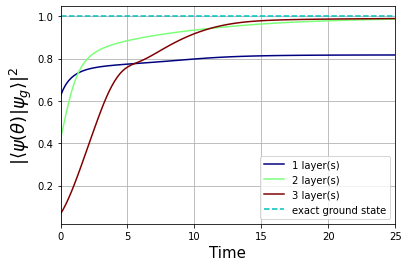

In [134]:
n = 3
colors = plt.cm.jet(np.linspace(0,1,n))

for kkk in range(3):
    plt.plot(time_domain,expt_value[kkk], color = colors[kkk],label = str(kkk+1)+" layer(s)")
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c",label = "exact ground state")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,25)
#plt.ylim(0.99,1)

plt.savefig("Imaginary_time_evolution_fidelity_over_layers_5qutrits_M=0.1.pdf")

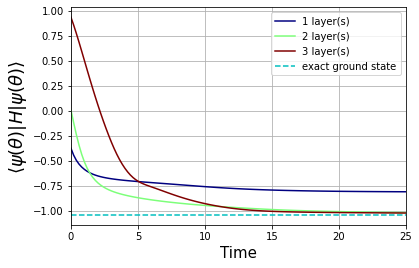

In [130]:
for kkk in range(3):
    plt.plot(time_domain,energyy[kkk], color = colors[kkk],label = str(kkk+1)+" layer(s)")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c",label = "exact ground state")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,25)
#plt.ylim(-0.65,-0.63)

plt.savefig("Imaginary_time_evolution_energy_over_layers_5qutrits_M=0.1.pdf")

###### import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [212]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [214]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [218]:
for i in range(coeff*N):
    print(Y[0][i])

0.37141536888406607
0.6602899660443315
0.11637371823579168
0.39901353290549235
0.9247979940631299
0.026453178512319396
0.4382807802429473
0.07025615093206115
0.3606296388374573
0.8138966259351307
0.9031720383192907
0.523454217057356
0.9272695715059814
0.9827474226150743
0.2639324508516817
0.41284186279042756
0.8757225556853009
0.523982524132141
0.9490899608210723
0.6202612047452045
0.19801202641088236
0.6716191124543176


(0.0, 10.0)

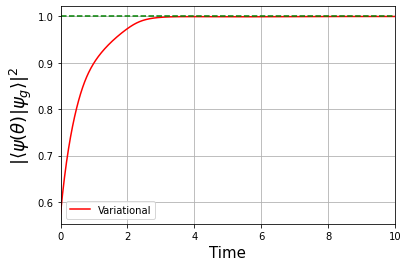

(0.0, 10.0)

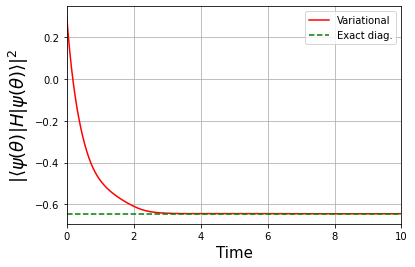

In [220]:
plt.plot(time_domain,energy, color = "red",label = "Variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="g", label = "Exact diag.")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_1.pdf")

In [221]:
print(expt_value_u[-1])

0.999481430342308


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
